In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from hmmlearn import hmm
import yfinance as yf

In [2]:
# Hidden Markov Model Modifiable Parameters
hidden_states = 3
em_iterations = 75
num_models = 8

# Date parameters for yfinance API
start_date = "1993-01-29"
end_date = "2020-04-01"

# Download data using yfinance instead of reading from CSV
# Use auto_adjust=True to get adjusted prices
df = yf.download('SPY', start=start_date, end=end_date, auto_adjust=True)

# Fix the multi-level column structure
df.columns = df.columns.droplevel(1)  # Remove the ticker level

# Reset index to make Date a column
df = df.reset_index()

# Display first few rows to check the structure
print("DataFrame structure after fixing:")
print("Data shape:", df.shape)
print("Data columns:", df.columns.tolist())
df.head()


[*********************100%***********************]  1 of 1 completed

DataFrame structure after fixing:
Data shape: (6842, 6)
Data columns: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']


Price,Date,Close,High,Low,Open,Volume
0,1993-01-29,24.452515,24.469906,24.348165,24.469906,1003200
1,1993-02-01,24.626438,24.626438,24.469914,24.469914,480500
2,1993-02-02,24.678612,24.696003,24.556871,24.609046,201300
3,1993-02-03,24.939472,24.956864,24.695991,24.713382,529400
4,1993-02-04,25.043833,25.096007,24.748176,25.026441,531500


In [3]:
# Print column names to verify what we have
print("Column names:", df.columns.tolist())

# Check if necessary columns exist
required_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in required_columns:
    if col not in df.columns:
        print(f"Warning: '{col}' column is missing!")

Column names: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']


In [4]:
# Volatility is computed by obtaining variance between current close and prices of past 10 days
Volatility = []

# MA is the 10 day SMA
MA = []

# Return is the single-day percentage return
Return = []
ma_sum = 0;

# Warming up data for moving average and volatility calculations
for i in range (0, 10):
    Volatility.append(0);
    MA.append(0);
    Return.append(0);
    ma_sum += df['Close'][i];

# Filling in data for return, moving average, and volatility
for ind in df.index: 
    if ind >= 10:
        tail_close = df['Close'][ind-10];
        prev_close = df['Close'][ind-1];
        head_close = df['Close'][ind];
        ma_sum = (ma_sum - tail_close + head_close);
        ma_curr = ma_sum/10;
        MA.append(ma_curr);
        Return.append(((head_close-prev_close)/prev_close)*100);
        #Computing Volatility
        vol_sum = 0;
        for i in range (0,10):
            curr_vol = abs(ma_curr - df['Close'][ind-i]);
            vol_sum += (curr_vol ** 2);
        Volatility.append(vol_sum/10);

# Adding columns to dataframe
df['Volatility'] = Volatility;
df['MA'] = MA;
df['Return'] = Return;

"""# With these calculations:
# Calculate Moving Average (10-day)
window = 10
df['MA'] = df['Close'].rolling(window=window).mean()

# Calculate Volatility (10-day)
df['Volatility'] = df['Close'].rolling(window=window).apply(lambda x: np.sqrt(np.sum((x - x.mean())**2)/len(x)))

# Calculate daily returns as percentage
df['Return'] = df['Close'].pct_change() * 100

# Drop rows with NaN values (first 'window' rows will have NaNs)
df = df.dropna().reset_index(drop=True)

print("Column names:", df.columns.tolist())
print("Data length:", len(df))
df.head()"""


'# With these calculations:\n# Calculate Moving Average (10-day)\nwindow = 10\ndf[\'MA\'] = df[\'Close\'].rolling(window=window).mean()\n\n# Calculate Volatility (10-day)\ndf[\'Volatility\'] = df[\'Close\'].rolling(window=window).apply(lambda x: np.sqrt(np.sum((x - x.mean())**2)/len(x)))\n\n# Calculate daily returns as percentage\ndf[\'Return\'] = df[\'Close\'].pct_change() * 100\n\n# Drop rows with NaN values (first \'window\' rows will have NaNs)\ndf = df.dropna().reset_index(drop=True)\n\nprint("Column names:", df.columns.tolist())\nprint("Data length:", len(df))\ndf.head()'

In [5]:
# Calculate total length of the dataframe
total_length = len(df)

# Determine drop and training lengths to match original analysis
# Original proportions: 
# total_length = 6843
# drop_length = 3508 (51.3% of total)
# training_length = 2706 (39.5% of total)
# test_length = 629 (9.2% of total)

drop_length = int(total_length * 0.513)
training_length = int(total_length * 0.395)
test_length = total_length - drop_length - training_length
data_length = training_length + test_length

print(f"Total length: {total_length}")
print(f"Drop length: {drop_length}")
print(f"Training length: {training_length}")
print(f"Test length: {test_length}")
print(f"Data length: {data_length}")

# Dataframe readjustment
df = df.iloc[drop_length:].copy()  # Use iloc instead of drop for cleaner index handling
df = df.reset_index(drop=True)  # Reset the index after dropping rows

Total length: 6842
Drop length: 3509
Training length: 2702
Test length: 631
Data length: 3333


In [6]:
# Creating testing and training dataset
test = df.iloc[training_length:].copy()
test = test.reset_index(drop=True)
training = df.iloc[:training_length].copy()

Available columns in training data: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Volatility', 'MA', 'Return']


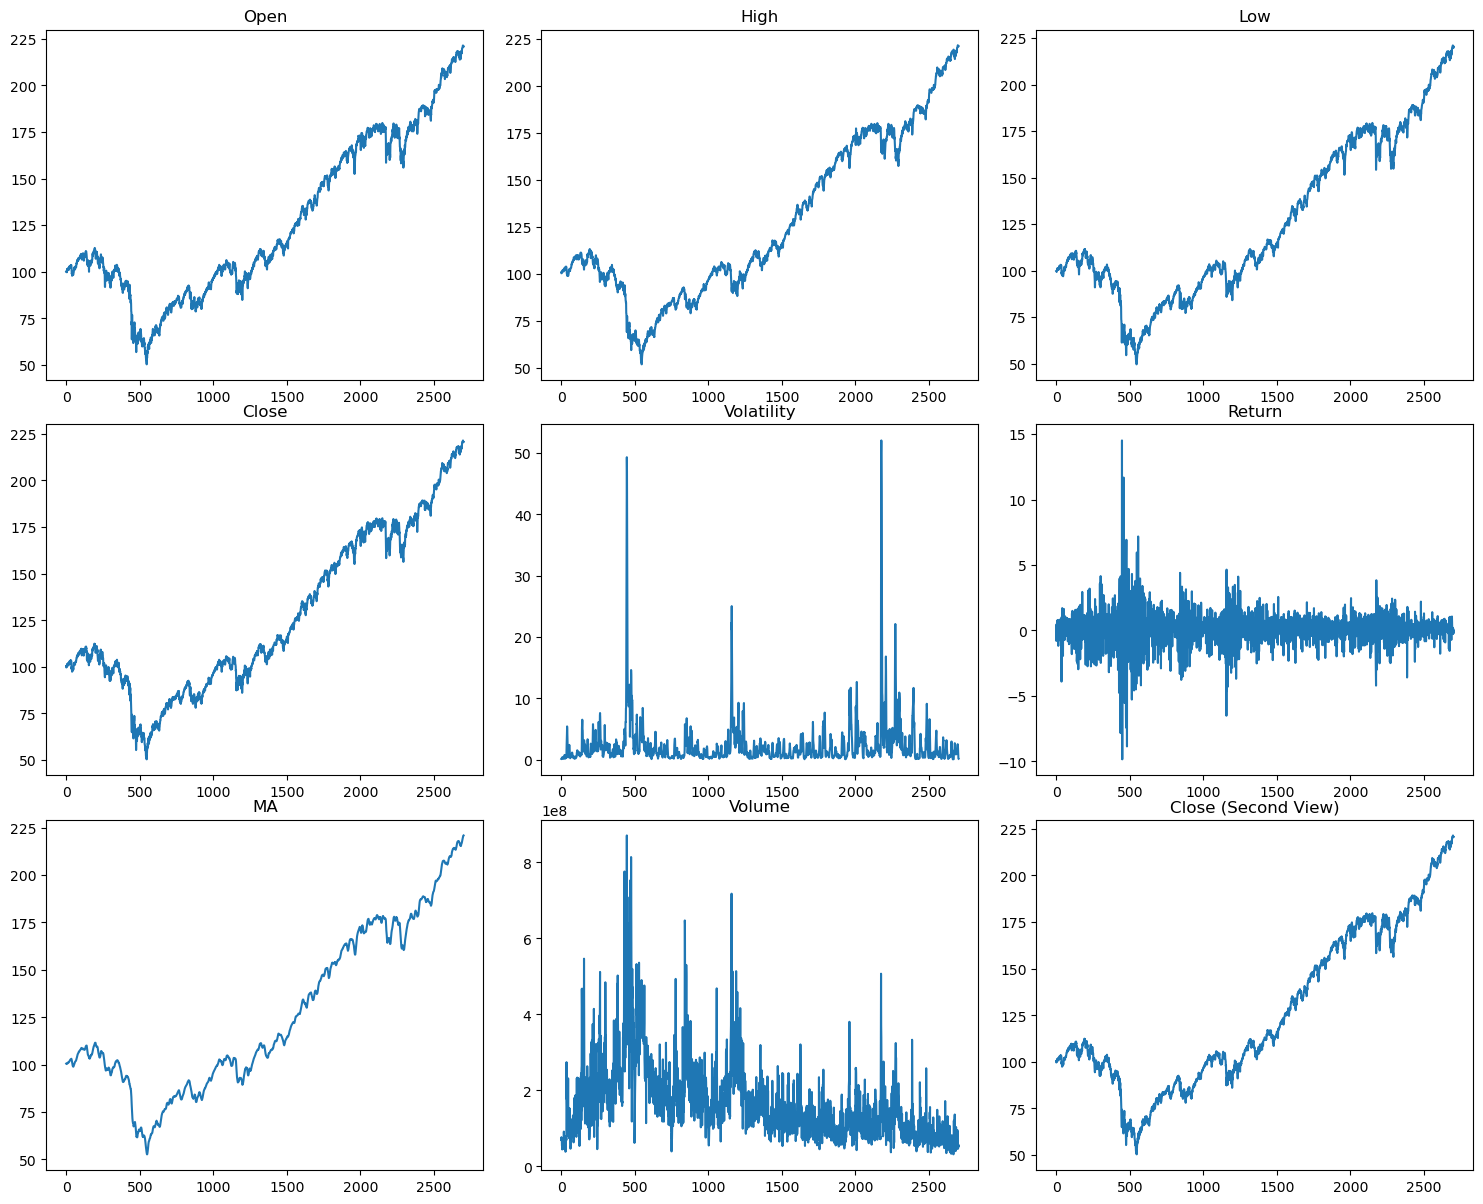

In [7]:
# Check available columns in training data
print("Available columns in training data:", training.columns.tolist())

fig, a = plt.subplots(3, 3, figsize=(15, 12))
x = np.arange(1, 5)
fig.tight_layout()
a[0][0].plot(range(0, len(training)), training['Open'])
a[0][0].set_title('Open')
a[0][1].plot(range(0, len(training)), training['High'])
a[0][1].set_title('High')
a[0][2].plot(range(0, len(training)), training['Low'])
a[0][2].set_title('Low')
a[1][0].plot(range(0, len(training)), training['Close'])
a[1][0].set_title('Close')
a[1][1].plot(range(0, len(training)), training['Volatility'])
a[1][1].set_title('Volatility')
a[1][2].plot(range(0, len(training)), training['Return'])
a[1][2].set_title('Return')
a[2][0].plot(range(0, len(training)), training['MA'])
a[2][0].set_title('MA')
a[2][1].plot(range(0, len(training)), training['Volume'])
a[2][1].set_title('Volume')
# Use third plot for date information
a[2][2].plot(range(0, len(training)), training['Close'])
a[2][2].set_title('Close (Second View)')
plt.show()

In [8]:
df.head()

Price,Date,Close,High,Low,Open,Volume,Volatility,MA,Return
0,2007-01-04,100.473259,100.742761,99.721502,100.161206,69620600,0.119315,100.543487,0.212170
1,2007-01-05,99.671875,100.281793,99.558410,100.232154,76645300,0.170860,100.424342,-0.797609
2,2007-01-08,100.132896,100.288923,99.466240,99.870493,71655000,0.160201,100.356969,0.462539
3,2007-01-09,100.047783,100.423662,99.572605,100.217986,75680100,0.167586,100.317966,-0.085001
4,2007-01-10,100.381096,100.402382,99.501687,99.700264,72428000,0.140126,100.373997,0.333154


In [9]:
# Creating the Hidden Markov Model
model = hmm.GaussianHMM(n_components=hidden_states, covariance_type="full", n_iter=em_iterations)
obs = np.column_stack([training['Volatility'].values, training['Return'].values])

# Fitting the model and obtaining predictions
model.fit(obs)
predictions = model.predict(obs)

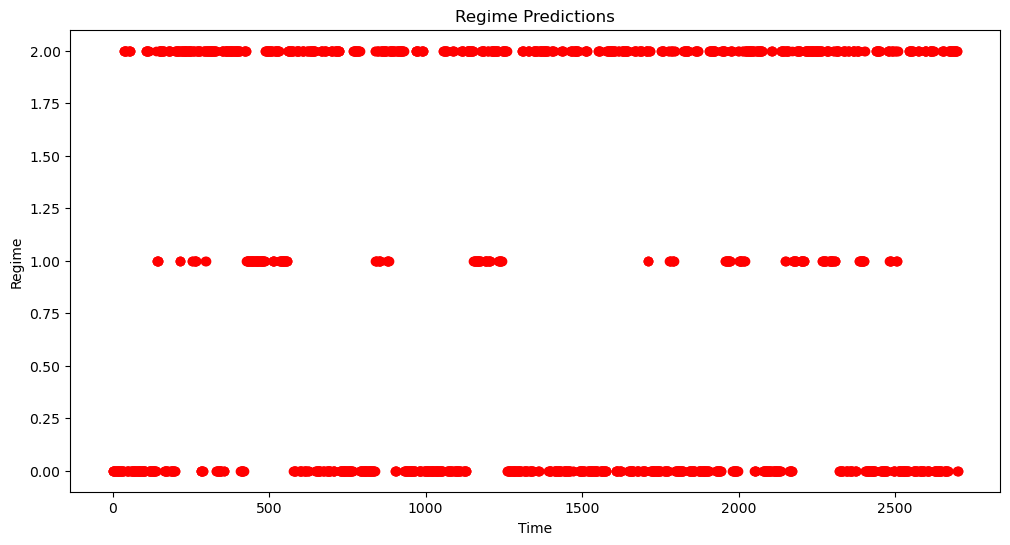

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(predictions, 'ro')
plt.title('Regime Predictions')
plt.xlabel('Time')
plt.ylabel('Regime')
plt.show()

In [11]:
# Regime Classification
regime_vol = [0] * hidden_states
regime_ret = [0] * hidden_states
regime_count = [0] * hidden_states
return_map = {i: [] for i in range(hidden_states)}

for i in range(len(predictions)):
    regime = predictions[i]
    regime_count[regime] += 1
    regime_vol[regime] += training['Volatility'].iloc[i]
    regime_ret[regime] += training['Return'].iloc[i]
    return_map[regime].append(training['Return'].iloc[i])
    
for i in range(hidden_states):
    if regime_count[i] > 0:  # Prevent division by zero
        regime_vol[i] = regime_vol[i] / regime_count[i]
        regime_ret[i] = regime_ret[i] / regime_count[i]

In [12]:
max_occurrence = np.argmax(regime_count)
for i in range(0, hidden_states):
    print(f"Regime {i}")
    print(f"Avg Vol: {regime_vol[i]}")
    print(f"Avg Return: {regime_ret[i]}")
    print(f"Occurrence: {regime_count[i]}\n")

Regime 0
Avg Vol: 0.6008960778890532
Avg Return: 0.05811672357162807
Occurrence: 1218

Regime 1
Avg Vol: 8.931664805397956
Avg Return: -0.07611031508661083
Occurrence: 311

Regime 2
Avg Vol: 2.2380105762826856
Avg Return: 0.04571401346378087
Occurrence: 1173



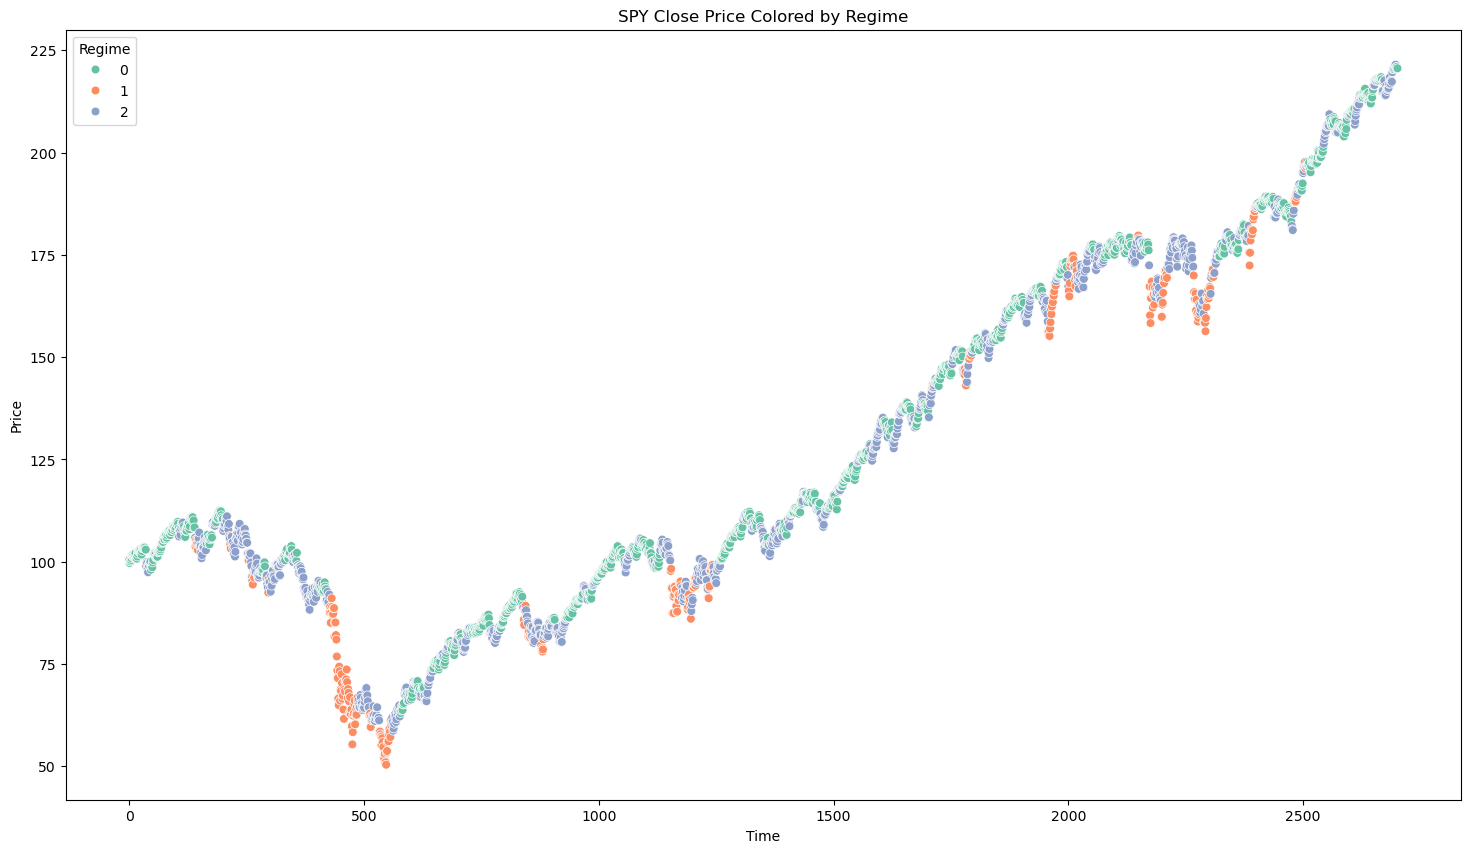

In [13]:
# Add the predictions to the training dataframe for visualization
training_with_predictions = training.copy()
training_with_predictions['Regime'] = predictions

# Create scatterplot with regimes
plt.figure(figsize=(18, 10))
sns.scatterplot(x=training_with_predictions.index, y='Close', 
                hue='Regime', data=training_with_predictions, 
                palette="Set2", s=40)
plt.title('SPY Close Price Colored by Regime')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

In [14]:
# Prepare returns dataframe for analysis
returns_data = {}
for i in range(hidden_states):
    returns_data[f'Regime_{i}'] = return_map[i]
    
# Create returns dataframe with the maximum length across all regimes
max_len = max(len(v) for v in return_map.values())
returns = pd.DataFrame()
for i in range(hidden_states):
    regime_returns = return_map[i] + [np.nan] * (max_len - len(return_map[i]))
    returns[f'Regime_{i}'] = regime_returns

In [15]:
distribution = model.get_stationary_distribution()
for i in range(0, hidden_states):
    print(f"Regime {i}: {distribution[i]}")

Regime 0: 0.446772885991537
Regime 1: 0.1164506565218597
Regime 2: 0.4367764574866032


In [16]:
print(f"Model Score: {model.score(obs)}")

Model Score: -7443.647259417941


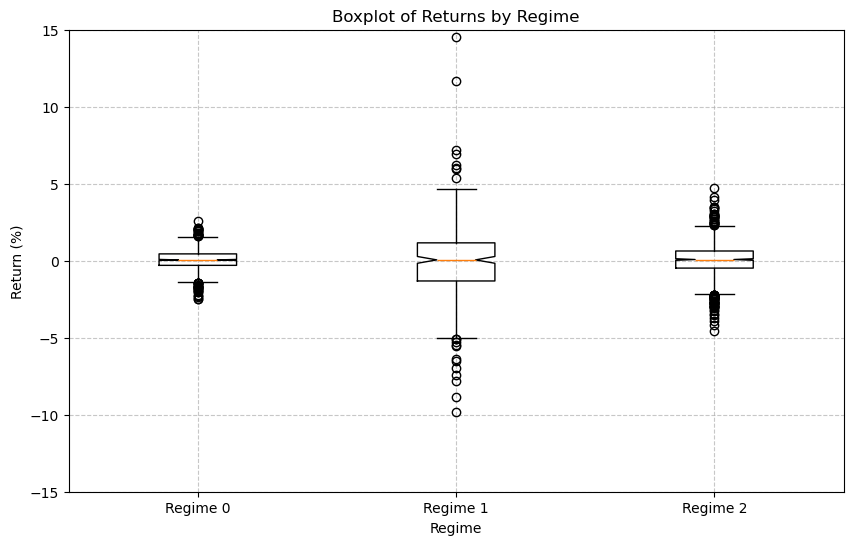

In [17]:
# Boxplot of returns
plt.figure(figsize=(10, 6))
data_to_plot = [return_map[i] for i in range(hidden_states)]
plt.boxplot(data_to_plot, notch=True, sym='o', vert=True, whis=1.5)
plt.ylim(-15, 15)
plt.title("Boxplot of Returns by Regime")
plt.xticks(range(1, hidden_states + 1), [f'Regime {i}' for i in range(hidden_states)])
plt.xlabel('Regime')
plt.ylabel('Return (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [18]:
# Calculate transition matrix
transition = pd.DataFrame(data=model.transmat_)
transition.index = [f'From Regime {i}' for i in range(hidden_states)]
transition.columns = [f'To Regime {i}' for i in range(hidden_states)]
print("Transition Matrix:")
transition

Transition Matrix:


,To Regime 0,To Regime 1,To Regime 2
From Regime 0,9.381583e-01,2.321805e-27,0.061842
From Regime 1,4.391107e-60,8.963519e-01,0.103648
From Regime 2,6.325706e-02,2.763401e-02,0.909109


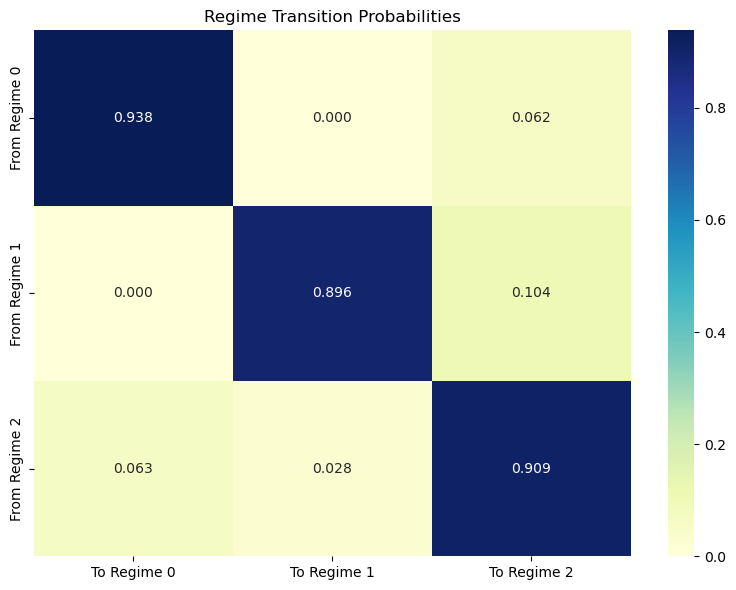

In [19]:
# Create a nicer visualization of the transition matrix
plt.figure(figsize=(8, 6))
sns.heatmap(model.transmat_, annot=True, cmap="YlGnBu", fmt=".3f",
            xticklabels=[f'To Regime {i}' for i in range(hidden_states)],
            yticklabels=[f'From Regime {i}' for i in range(hidden_states)])
plt.title('Regime Transition Probabilities')
plt.tight_layout()
plt.show()

In [20]:
# Create a function to predict the current regime
def predict_regime(close_prices, volatility_window=10):
    # Ensure we have enough data
    if len(close_prices) < volatility_window + 1:
        raise ValueError(f"Need at least {volatility_window + 1} price points")
        
    # Calculate MA
    ma = sum(close_prices[:volatility_window]) / volatility_window
    
    # Calculate volatility
    volatility = 0
    for i in range(volatility_window):
        curr_vol = abs(ma - close_prices[i])
        volatility += (curr_vol ** 2)
    volatility /= volatility_window
    
    # Calculate return
    ret = ((close_prices[-1] - close_prices[-2]) / close_prices[-2]) * 100
    
    # Predict regime
    observation = np.array([[volatility, ret]])
    regime = model.predict(observation)[0]
    
    return regime, volatility, ret

In [21]:
# Test the prediction function with the latest data from our dataset
latest_prices = df['Close'].iloc[-11:].values
current_regime, vol_value, ret_value = predict_regime(latest_prices)

print(f"Current Regime: {current_regime}")
print(f"Current Volatility: {vol_value:.4f}")
print(f"Current Return: {ret_value:.4f}%")
print(f"Expected Average Return in this Regime: {regime_ret[current_regime]:.4f}%")

Current Regime: 1
Current Volatility: 128.0005
Current Return: -1.4905%
Expected Average Return in this Regime: -0.0761%


In [22]:
# Let's also get some recent data to test our model on current market conditions
import datetime as dt

# Get today's date
today = dt.datetime.now().strftime('%Y-%m-%d')
# Get data for the last 30 days
recent_data = yf.download('SPY', start=dt.datetime.now() - dt.timedelta(days=30), end=today, auto_adjust=True)

# Apply our regime detection to recent data if we have enough data points
if len(recent_data) > 11:
    latest_prices_recent = recent_data['Close'].tail(11).values
    current_regime_recent, vol_value_recent, ret_value_recent = predict_regime(latest_prices_recent)
    
    print(f"Current Market Regime (Recent Data): {current_regime_recent}")
    print(f"Current Volatility: {vol_value_recent:.4f}")
    print(f"Current Return: {ret_value_recent:.4f}%")
    print(f"Expected Average Return in this Regime: {regime_ret[current_regime_recent]:.4f}%")
    
    # Compare with regime characteristics
    print("\nRegime Characteristics:")
    for i in range(hidden_states):
        print(f"Regime {i}: Volatility = {regime_vol[i]:.4f}, Return = {regime_ret[i]:.4f}%")
else:
    print("Not enough recent data points for regime prediction")


[*********************100%***********************]  1 of 1 completed


ValueError: Found array with dim 3. None expected <= 2.

In [ ]:
# Optional: Save model for future use
import joblib
joblib.dump(model, 'hmm_market_regime_model.pkl')
print("Model saved to 'hmm_market_regime_model.pkl'")

# Also save the regime statistics for reference
regime_stats = pd.DataFrame({
    'Volatility': regime_vol,
    'Return': regime_ret,
    'Occurrence': regime_count,
    'Probability': distribution
})
regime_stats.index = [f'Regime_{i}' for i in range(hidden_states)]
regime_stats.to_csv('hmm_regime_statistics.csv')
print("Regime statistics saved to 'hmm_regime_statistics.csv'")